As always, import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
#import seaborn as sns

# custom functions for data preparation
import helper as ff

# Supervised learning

In this notebook, we will train a Random Forest Classifier on the soccer data we handled in the notebook *1_Analysis_and_Cleaning*.

We start by selecting a first set of features and exploring various parameters for the classifier. After obtaining results for this first set, we test two other groups of features.

We discuss our results and their possible causes.

First, we import the numeric data we prepared:

In [2]:
df = pd.read_csv('data/players.csv')
df.head()

,goals,birthday,skin_colour,victories,leagueCountry,weight,ties,position,yellowCards,redCards,...,club,gravity,meanIAT_yellowCards,meanIAT_yellowReds,meanIAT_redCards,meanIAT_gravity,meanExp_yellowCards,meanExp_yellowReds,meanExp_redCards,meanExp_gravity
0,9,1979,0,247,0,71,179,1,19,0,...,34,19.000000,0.011600,0.000000,0.000000,0.011600,0.012772,0.000000,0.000000,0.012772
1,62,1986,0,141,2,73,73,0,42,1,...,87,73.305853,0.036043,0.000000,0.000297,0.045332,0.041615,0.000000,0.000358,0.052832
2,31,1987,0,200,0,63,97,10,11,0,...,80,11.000000,0.006122,0.000000,0.000000,0.006122,0.006491,0.000000,0.000000,0.006491
3,39,1990,0,150,0,76,42,3,31,1,...,6,62.305853,0.043839,0.000000,0.003702,0.159734,0.049627,0.000000,0.004433,0.188418
4,1,1990,0,41,1,73,40,1,8,2,...,49,203.000262,0.023945,0.014914,0.004162,0.647860,0.028676,0.017878,0.004985,0.776431


In [3]:
list(df.columns.unique())

['goals',
 'birthday',
 'skin_colour',
 'victories',
 'leagueCountry',
 'weight',
 'ties',
 'position',
 'yellowCards',
 'redCards',
 'defeats',
 'yellowReds',
 'height',
 'games',
 'club',
 'gravity',
 'meanIAT_yellowCards',
 'meanIAT_yellowReds',
 'meanIAT_redCards',
 'meanIAT_gravity',
 'meanExp_yellowCards',
 'meanExp_yellowReds',
 'meanExp_redCards',
 'meanExp_gravity']

## Which classification?
Remember, the *skin_colour* column is actually the average rating over the two raters. Let's bring up its values:

In [4]:
df.skin_colour.unique()

array([0, 1])

In [5]:
df.isnull().any()

goals                  False
birthday               False
skin_colour            False
victories              False
leagueCountry          False
weight                 False
ties                   False
position               False
yellowCards            False
redCards               False
defeats                False
yellowReds             False
height                 False
games                  False
club                   False
gravity                False
meanIAT_yellowCards    False
meanIAT_yellowReds     False
meanIAT_redCards       False
meanIAT_gravity        False
meanExp_yellowCards    False
meanExp_yellowReds     False
meanExp_redCards       False
meanExp_gravity        False
dtype: bool

As it stands, there are 2 values that encode skin colour. THerefore, it's a binary classifier: People are either *black* or *white*. 

# Supervised Learning! 

For the Supervised Learning, we will do four tests:
1. Classifier with all the features
2. Classifier with the features containing some racism
3. Classifier with the features that do not contain racism
4. Classifier with selected features

## 1.  Classifier with all the features

For the first test, we want to use all the features.

In [6]:
# comment out the features you want to pass to the classifier!
cols1 = [#'yellowReds',
         #'ties',
         #'redCards',
         #'weight',
         #'height',
         #'defeats',
         #'games',
         #'victories',
         #'yellowCards',
         #'position',
         #'leagueCountry',
         #'goals',
         #'club',
         'skin_colour', # We never want the skin colour
         #'birthday',
         #'gravity',
         #'meanIAT_yellowCards',
         #'meanIAT_yellowReds',
         #'meanIAT_redCards',
         #'meanIAT_gravity',
         #'meanExp_yellowCards',
         #'meanExp_yellowReds',
         #'meanExp_redCards',
         #'meanExp_gravity'
        ]

We prepare our data in the correct format with the help of functions stored in *helper.py*.

In [7]:
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols1)

df shape: (1433, 24)
data shape: (1433, 23)
target shape: (1433,)


Let's check if there is any class imbalance:

In [8]:
x = df.skin_colour
x.value_counts()

0    1203
1     230
Name: skin_colour, dtype: int64

As it turns out, there is a huge class imbalance. We will see later wether it's a problem for us. We just check the percentage to have a better idea than just numbers.

In [9]:
x.value_counts()*100/x.count()

0    83.949756
1    16.050244
Name: skin_colour, dtype: float64

### Setting the parameters
One parameter we're interested in when instantiating a random forest is its number of estimators. 

Thus, we iterate over a number of forests with a different number of estimators and use the OOB score to figure out how many estimators is enough. Our *ff.train_test_RF()* function performs a train/test split on the data to train the random forest. It also holds some data out of the train/test samples, to perform a check on data the classifier hasn't seen before.

In [10]:
oob = []
start = 20
end = 300
for i in range(start, end, 1):
    forest = RandomForestClassifier(n_estimators = i, max_features=0.33, max_depth=10, n_jobs=-1, oob_score=True);
    forest, acc = ff.train_test_RF(forest, data, target, 150);
    oob.append(1-forest.oob_score_);
    if ((i-start)+1)%10 == 0:
        print("%i/%i done!"%((i-start)+1, end-start))
print("All done!")

10/280 done!
20/280 done!
30/280 done!
40/280 done!
50/280 done!
60/280 done!
70/280 done!
80/280 done!
90/280 done!
100/280 done!
110/280 done!
120/280 done!
130/280 done!
140/280 done!
150/280 done!
160/280 done!
170/280 done!
180/280 done!
190/280 done!
200/280 done!
210/280 done!
220/280 done!
230/280 done!
240/280 done!
250/280 done!
260/280 done!
270/280 done!
280/280 done!
All done!


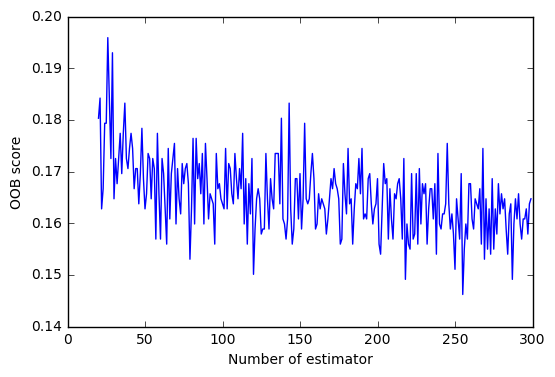

In [11]:
plt.plot(range(start, end, 1), oob, '-')
plt.xlabel('Number of estimator')
plt.ylabel('OOB score')

As we can see, although it is still rough, the error starts to stabilise between 100 and 200 estimators. We'll use 200 estimators to be sure.

We do the same to set the depth parameter. This time, we use the accuracy score on the held-out sample.

In [12]:
acc = []
for i in range(1, 50, 1):
    forest = RandomForestClassifier(n_estimators = 200, max_features=0.33, max_depth=i, n_jobs=-1, oob_score=True);
    forest, accuracy = ff.train_test_RF(forest, data, target, 150);
    acc.append(1-accuracy);
    if (i+1)%10 == 0:
        print("%i/%i done!"%((i+1, 50)))
print("All done!")

10/50 done!
20/50 done!
30/50 done!
40/50 done!
50/50 done!
All done!


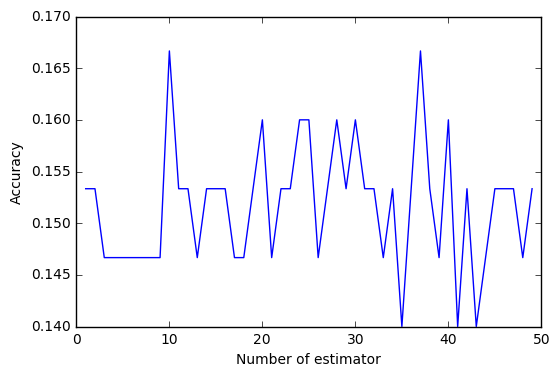

In [13]:
plt.plot(range(1, 50, 1), acc, '-')
plt.xlabel('Number of estimator')
plt.ylabel('Accuracy')

Here we see that it seems better to have a *max_depth* of only ~10.

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold to do so. Also, we hold out same data to see how our classifier behaves on data it hasn't seen before.

In [14]:
# preparing the hold-out data
n = round(0.8*len(target))
data_holdout = data[n:,]
target_holdout = target[n:]
data = data[:n,]
target = target[:n]

# we will keep track of the accuracy
acc = []
forest = RandomForestClassifier(n_estimators = 200, max_features=0.33, max_depth=10, n_jobs=-1)
kf = KFold(n_splits=20)

for train, test in kf.split(data):
    forest.fit(data[train], target[train])
    # keeping track of the accuracy
    predi = forest.predict(data[test])
    acc.append(metrics.accuracy_score(predi, target[test]))

First, let's see how it behaves on the data it has already worked on:

In [15]:
pred = forest.predict(data)
metrics.accuracy_score(pred, target)

0.96335078534031415

At first sight, this doesn't seem too bad. But *accuracy* might not be a good measure here. Remember, we have a strong class imbalance. 

To get a clearer picture, we separate our target and prediction data into the two classes and check accuracy for each class.

In [16]:
target0, target1 = ff.details(pred, target)

# of people with light skin: 956
# of people with dark skin: 190
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.778947368421


We see here that 100% of the white people are found as being white. But only 77% of the black people are found as being black. Let's check the confusion matrix to be sure.

In [17]:
cnf = metrics.confusion_matrix(target, pred)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [ 22,  77]])

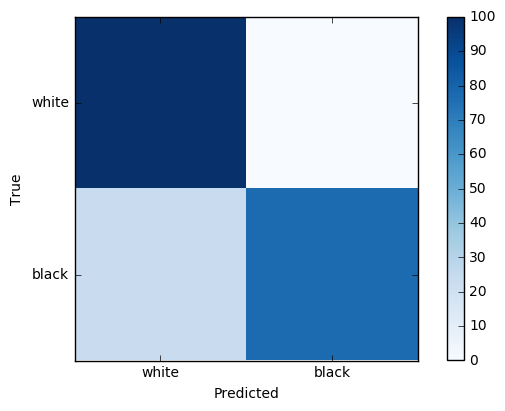

In [18]:
ff.plot_cnf(cnf, ['white', 'black'])

It is clear from the confusion matrix that our random forest is biased towards the *light skin* class.

We check the results on the data we held out:

In [19]:
predi = forest.predict(data_holdout)
metrics.accuracy_score(predi, target_holdout)

0.86411149825783973

In [20]:
target0, target1 = ff.details(predi, target_holdout)

# of people with light skin: 247
# of people with dark skin: 40
 
accuracy for light skin: 0.995951417004
accuracy for dark skin: 0.05


In [21]:
cnf = metrics.confusion_matrix(target_holdout, predi)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[99,  0],
       [95,  5]])

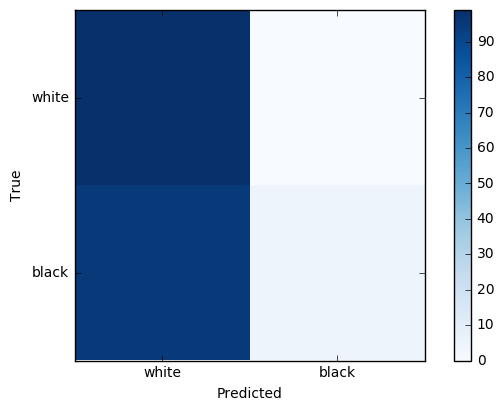

In [22]:
ff.plot_cnf(cnf, ['white', 'black'])

The predictions are worse here, with almost all dark skinned players classified as light skinned.

The huge class imbalance probably explains it.

### Feature importances

Let's check the feature importances:

In [23]:
imp = forest.feature_importances_

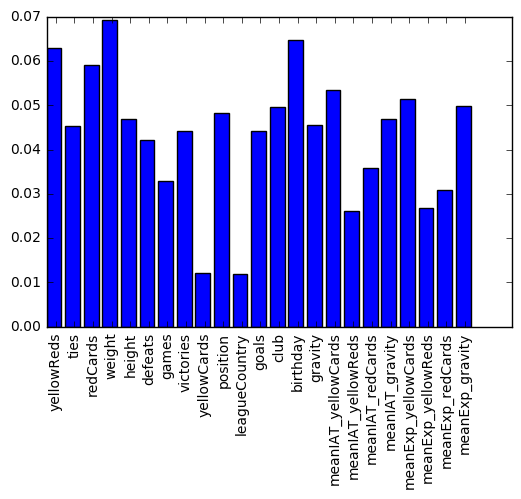

In [24]:
ff.impo_graph(imp, labels)

We see here that the feature importance is kinda weird. Indeed, we see that the most important feature is the *birthday*. It's not normal at all. It may be because we have too much features here. Therefore, let's try with the feature having some kind of racism inside.

## 2.  Classifier with the "racist" features

As a test, we train a random forest on all the features of our data that have a link to player-referee interactions, and thus may contain a hint of racism.

In [25]:
# comment out the features you want to pass to the classifier!
cols2 = [#'yellowReds',
         'ties',
         #'redCards',
         'weight',
         'height',
         'defeats',
         'games',
         'victories',
         #'yellowCards',
         'position',
         'leagueCountry',
         'goals',
         'club',
         'skin_colour', # We never want the skin colour
         'birthday',
         #'gravity',
         #'meanIAT_yellowCards',
         #'meanIAT_yellowReds',
         #'meanIAT_redCards',
         #'meanIAT_gravity',
         #'meanExp_yellowCards',
         #'meanExp_yellowReds',
         #'meanExp_redCards',
         #'meanExp_gravity'
        ]

We prepare our data in the correct format with the help of functions stored in *helper.py*.

In [26]:
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols2)

df shape: (1433, 24)
data shape: (1433, 12)
target shape: (1433,)


### Parameters

We will use the same parameters as found the first time being:
- `depth` of 10
- `Number of estimators` of 200

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold to do so. Also, we hold out same data to see how our classifier behaves on data it hasn't seen before.

In [27]:
# preparing the hold-out data
n = round(0.8*len(target))
data_holdout = data[n:,]
target_holdout = target[n:]
data = data[:n,]
target = target[:n]

# we will keep track of the accuracy
acc = []
forest = RandomForestClassifier(n_estimators = 200, max_features=0.33, max_depth=10, n_jobs=-1)
kf = KFold(n_splits=20)

for train, test in kf.split(data):
    forest.fit(data[train], target[train])
    # keeping track of the accuracy
    predi = forest.predict(data[test])
    acc.append(metrics.accuracy_score(predi, target[test]))

First, let's see how it behaves on the data it has already worked on:

In [28]:
pred = forest.predict(data)
metrics.accuracy_score(pred, target)

0.8778359511343804

At first sight, this doesn't seem too bad. But *accuracy* might not be a good measure here. Remember, we have a strong class imbalance. 

To get a clearer picture, we separate our target and prediction data into the two classes and check accuracy for each class.

In [29]:
target0, target1 = ff.details(pred, target)

# of people with light skin: 956
# of people with dark skin: 190
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.263157894737


Something is clearly going awry here. We check the confusion matrix for a clearer picture.

In [30]:
cnf = metrics.confusion_matrix(target, pred)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [ 73,  26]])

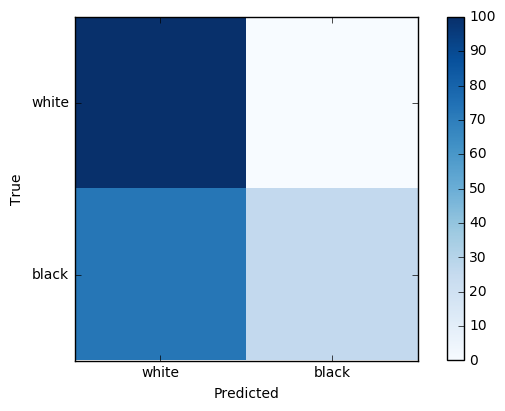

In [31]:
ff.plot_cnf(cnf, ['white', 'black'])

It is clear from the confusion matrix that our random forest is very much biased towards the *light skin* class. Almost all dark-skinned players are classified as light-skinned.

We check the results on the data we held out:

In [32]:
predi = forest.predict(data_holdout)
metrics.accuracy_score(predi, target_holdout)

0.8571428571428571

In [33]:
target0, target1 = ff.details(predi, target_holdout)

# of people with light skin: 247
# of people with dark skin: 40
 
accuracy for light skin: 0.995951417004
accuracy for dark skin: 0.0


In [34]:
cnf = metrics.confusion_matrix(target_holdout, predi)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[ 99,   0],
       [100,   0]])

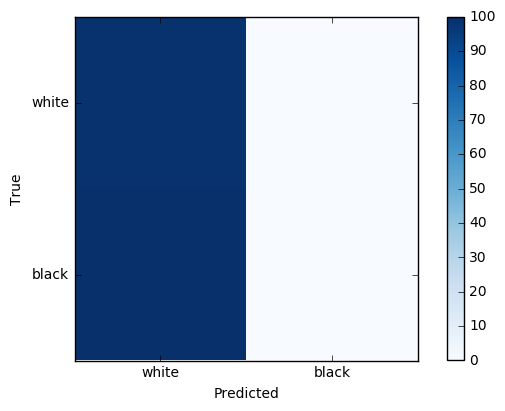

In [35]:
ff.plot_cnf(cnf, ['white', 'black'])

The predictions are even worse here, with all dark skinned players classified as light skinned.

The huge class imbalance probably explains it.

### Feature importances

Let's check the feature importances:

In [36]:
imp = forest.feature_importances_

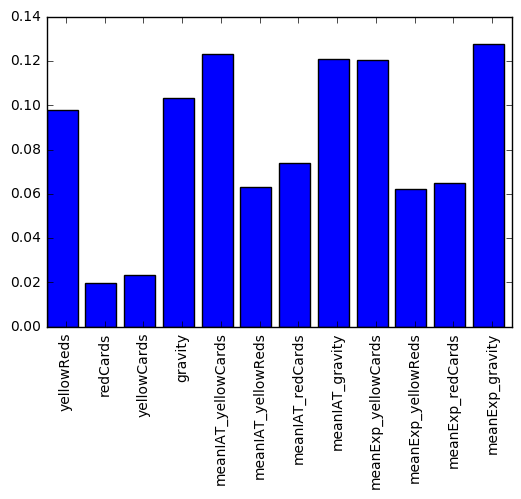

In [37]:
ff.impo_graph(imp, labels)

It seems that more importance is given to the features involving `meanIAT` and `meanExp` combined with `gravity` and `yellowCard`. The other useful features are `gravity` and `yellowReds`

## 3.  Classifier with the "non-racist" features


The first results were quite disappointing. Let's try to train the classifier on the features that have nothing to do with player-referee interactions.

In [38]:
# comment out the features you want to pass to the classifier!
cols3 = ['yellowReds',
         #'ties',
         'redCards',
         #'weight',
         #'height',
         #'defeats',
         #'games',
         #'victories',
         'yellowCards',
         #'position',
         #'leagueCountry',
         #'goals',
         #'club',
         'skin_colour', # We never want the skin colour
         #'birthday',
         'gravity',
         'meanIAT_yellowCards',
         'meanIAT_yellowReds',
         'meanIAT_redCards',
         'meanIAT_gravity',
         'meanExp_yellowCards',
         'meanExp_yellowReds',
         'meanExp_redCards',
         'meanExp_gravity'
        ]

We prepare our data in the correct format with the help of functions stored in *helper.py*.

In [39]:
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols3)

df shape: (1433, 24)
data shape: (1433, 11)
target shape: (1433,)


### Parameters

We will use the same parameters as found the first time being:
- `depth` of 10
- `Number of estimators` of 200

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold to do so. Also, we hold out same data to see how our classifier behaves on data it hasn't seen before.

In [40]:
# preparing the hold-out data
n = round(0.8*len(target))
data_holdout = data[n:,]
target_holdout = target[n:]
data = data[:n,]
target = target[:n]

# we will keep track of the accuracy
acc = []
forest = RandomForestClassifier(n_estimators = 200, max_features=0.33, max_depth=10, n_jobs=-1)
kf = KFold(n_splits=20)

for train, test in kf.split(data):
    forest.fit(data[train], target[train])
    # keeping track of the accuracy
    predi = forest.predict(data[test])
    acc.append(metrics.accuracy_score(predi, target[test]))

First, let's see how it behaves on the data it has already worked on:

In [41]:
pred = forest.predict(data)
metrics.accuracy_score(pred, target)

0.95898778359511339

At first sight, this doesn't seem too bad. But *accuracy* might not be a good measure here. Remember, we have a strong class imbalance. 

To get a clearer picture, we separate our target and prediction data into the two classes and check accuracy for each class.

In [42]:
target0, target1 = ff.details(pred, target)

# of people with light skin: 956
# of people with dark skin: 190
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.752631578947


Something is clearly going awry here. We check the confusion matrix for a clearer picture.

In [43]:
cnf = metrics.confusion_matrix(target, pred)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [ 24,  75]])

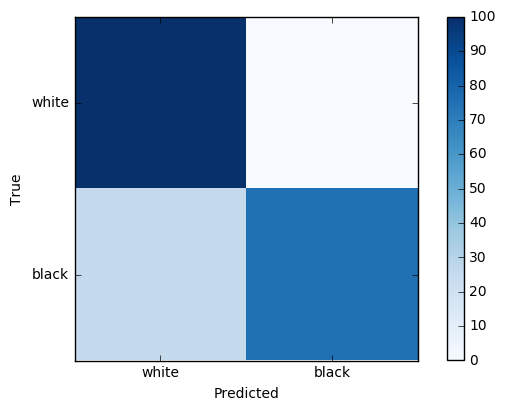

In [44]:
ff.plot_cnf(cnf, ['white', 'black'])

It is clear from the confusion matrix that our random forest is very much biased towards the *light skin* class. Almost all dark-skinned players are classified as light-skinned.

We check the results on the data we held out:

In [45]:
predi = forest.predict(data_holdout)
metrics.accuracy_score(predi, target_holdout)

0.87804878048780488

In [46]:
target0, target1 = ff.details(predi, target_holdout)

# of people with light skin: 247
# of people with dark skin: 40
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.125


In [47]:
cnf = metrics.confusion_matrix(target_holdout, predi)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [ 87,  12]])

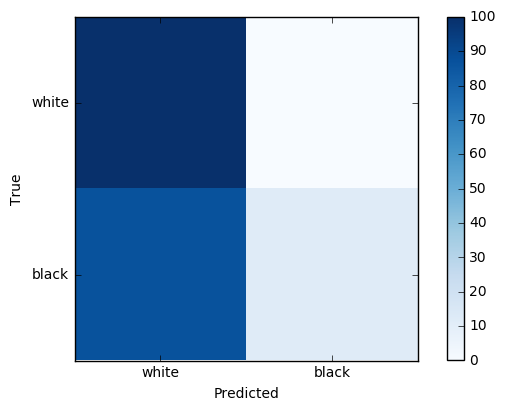

In [48]:
ff.plot_cnf(cnf, ['white', 'black'])

The predictions are not better than on the training set, with almost all dark skinned players classified as light skinned.

The huge class imbalance probably explains it.

### Feature importances

Let's check the feature importances:

In [49]:
imp = forest.feature_importances_

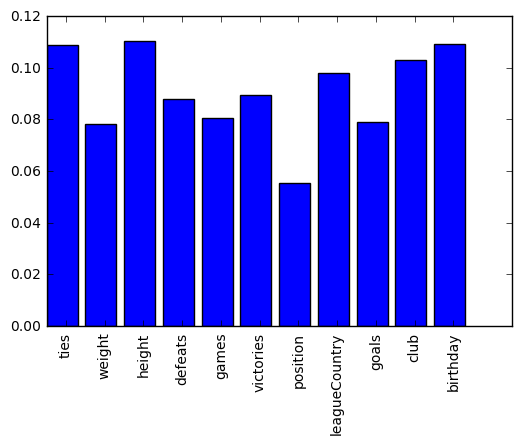

In [50]:
ff.impo_graph(imp, labels)

All the features seems important here. Even if all these features should not give any indication on the color of a player

## 4.  Classifier with chosen features


Let's choose some features according the feature importance we saw the three first times.

In [51]:
# comment out the features you want to pass to the classifier!
cols4 = ['yellowReds',
         'ties',
         'redCards',
         #'weight',
         'height',
         'defeats',
         'games',
         'victories',
         'yellowCards',
         #'position',
         'leagueCountry',
         'goals',
         'club',
         'skin_colour', # We never want the skin colour
         #'birthday',
         #'gravity',
         #'meanIAT_yellowCards',
         'meanIAT_yellowReds',
         'meanIAT_redCards',
         #'meanIAT_gravity',
         #'meanExp_yellowCards',
         'meanExp_yellowReds',
         'meanExp_redCards',
         #'meanExp_gravity'
        ]

We prepare our data in the correct format with the help of functions stored in *helper.py*.

In [52]:
# transform the df into np matrix
data, target, labels = ff.prepare_data(df, cols4)

df shape: (1433, 24)
data shape: (1433, 8)
target shape: (1433,)


### Parameters

We will use the same parameters as found the first time being:
- `depth` of 10
- `Number of estimators` of 200

### Cross-validation

We fit our random forest classifier using cross-validation, so as to avoid overfitting. We use KFold to do so. Also, we hold out same data to see how our classifier behaves on data it hasn't seen before.

In [53]:
# preparing the hold-out data
n = round(0.8*len(target))
data_holdout = data[n:,]
target_holdout = target[n:]
data = data[:n,]
target = target[:n]

# we will keep track of the accuracy
acc = []
forest = RandomForestClassifier(n_estimators = 200, max_features=0.33, max_depth=10, n_jobs=-1)
kf = KFold(n_splits=20)

for train, test in kf.split(data):
    forest.fit(data[train], target[train])
    # keeping track of the accuracy
    predi = forest.predict(data[test])
    acc.append(metrics.accuracy_score(predi, target[test]))

First, let's see how it behaves on the data it has already worked on:

In [54]:
pred = forest.predict(data)
metrics.accuracy_score(pred, target)

0.88219895287958117

At first sight, this doesn't seem too bad. But *accuracy* might not be a good measure here. Remember, we have a strong class imbalance. 

To get a clearer picture, we separate our target and prediction data into the two classes and check accuracy for each class.

In [55]:
target0, target1 = ff.details(pred, target)

# of people with light skin: 956
# of people with dark skin: 190
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.289473684211


Something is clearly going awry here. We check the confusion matrix for a clearer picture.

In [56]:
cnf = metrics.confusion_matrix(target, pred)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [ 71,  28]])

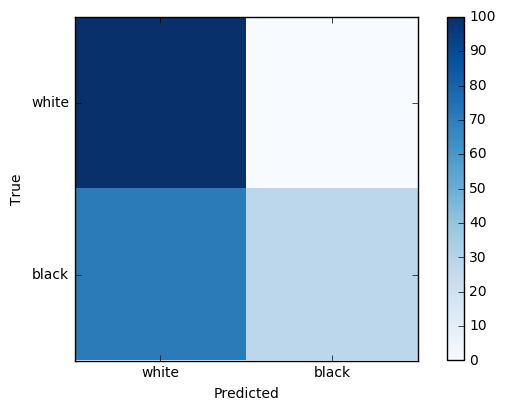

In [57]:
ff.plot_cnf(cnf, ['white', 'black'])

It is clear from the confusion matrix that our random forest is very much biased towards the *light skin* class. Almost all dark-skinned players are classified as light-skinned.

We check the results on the data we held out:

In [58]:
predi = forest.predict(data_holdout)
metrics.accuracy_score(predi, target_holdout)

0.86062717770034847

In [59]:
target0, target1 = ff.details(predi, target_holdout)

# of people with light skin: 247
# of people with dark skin: 40
 
accuracy for light skin: 1.0
accuracy for dark skin: 0.0


In [60]:
cnf = metrics.confusion_matrix(target_holdout, predi)
cnf[0] = cnf[0]/len(target0)*100
cnf[1] = cnf[1]/len(target1)*100
cnf

array([[100,   0],
       [100,   0]])

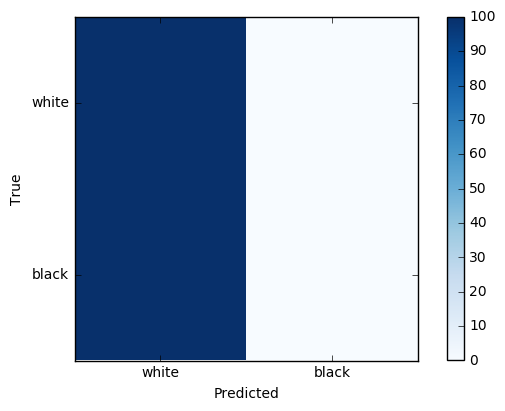

In [61]:
ff.plot_cnf(cnf, ['white', 'black'])

The predictions are not better than on the training set, with all dark skinned players classified as light skinned.

The huge class imbalance probably explains it.

### Feature importances

Let's check the feature importances:

In [62]:
imp = forest.feature_importances_

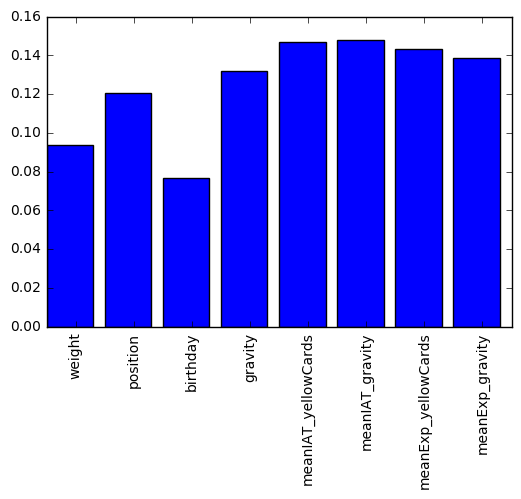

In [63]:
ff.impo_graph(imp, labels)

# Discussion

Whatever the set of features selected, we obtained poor results when it comes to accurately classifying players, in particular those with dark skin. Careful selection of equally sized samples would eliminate class imbalance and might help. The problem is that the resulting data would be of small size.

While the class imbalance probably plays a big role, we believe the conclusion to be drawn here is that the data we have simply does not allow us to predict skin colour.

Furthermore, the fact that we didn't obtain worse results when considering non-racism-related features could be invoked to assert that referee racism and behavior is not strong enough to predict players' skin colour. That's good news!

# Bonus

Code reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

With the help of the code mentioned above, we plot the learning curves for our *first* and *third* sets of features.

df shape: (1433, 24)
data shape: (1433, 23)
target shape: (1433,)


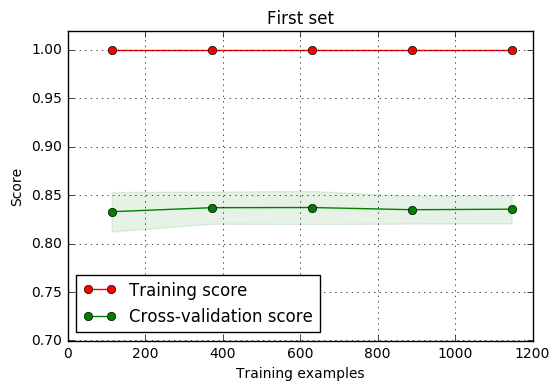

In [64]:
# First set of features
data, target, labels = ff.prepare_data(df, cols1)
ff.make_learning_curve(data, target, 'First set')

df shape: (1433, 24)
data shape: (1433, 12)
target shape: (1433,)


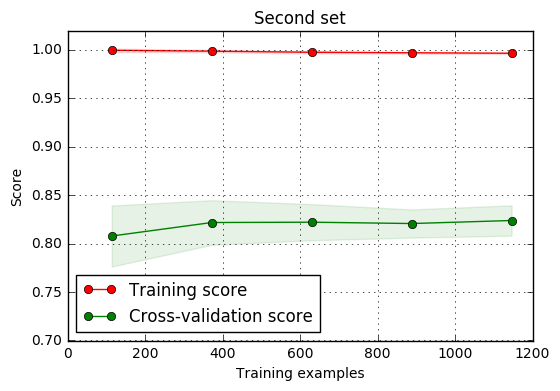

In [65]:
# Second set of features
data, target, labels = ff.prepare_data(df, cols2)
ff.make_learning_curve(data, target, 'Second set')

df shape: (1433, 24)
data shape: (1433, 11)
target shape: (1433,)


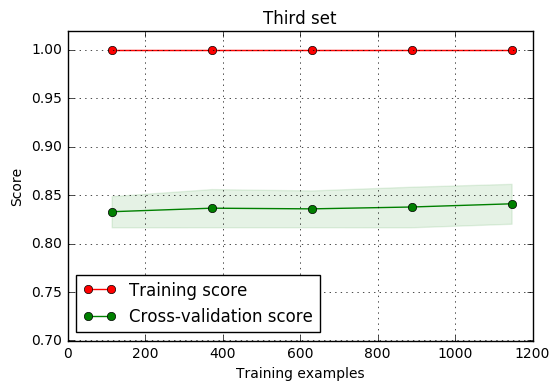

In [66]:
# Third set of features
data, target, labels = ff.prepare_data(df, cols3)
ff.make_learning_curve(data, target, 'Third set')

df shape: (1433, 24)
data shape: (1433, 8)
target shape: (1433,)


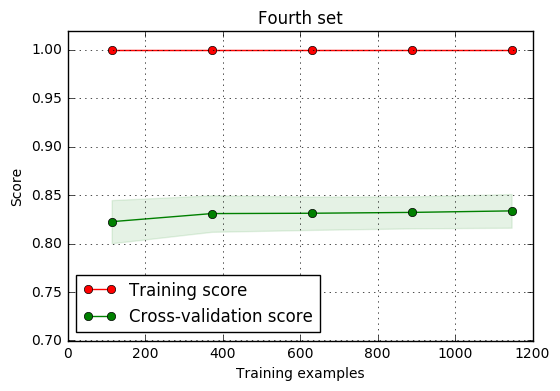

In [67]:
# Fourth set of features
data, target, labels = ff.prepare_data(df, cols4)
ff.make_learning_curve(data, target, 'Fourth set')

It is interesting to see that almost all the time, the training curve has an accuracy of one. It seems that it can classify pretty correctly with the given data. But when we use it on testing data, then it becomes worse. 

At the end, we see that even with cross-validation, the results does not get better. The disproportionality between the "white" and "black" players is too big. Or it's simpy that this dataset does not have enough features to be able to predict the color of the players.

This reflects the discussion above. Checking every possible combination of features would be far too long. We believe however that the data is such that no group of features would lead to better results on this classification problem.